In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2
%cd ../src

import torch
from torch.nn import Sequential
from torch.nn import Softmax
from pytorch_fcn.fcn32s import FCN32s
import data_utils
from data_utils import DataConfig
from plot_utils import show, show_normalized

import vinsight
from vinsight.uncertainty import modules

/home/fabian/Projects/interpretability-framework/src


# vinsight - Uncertainty Tutorial 2
in this notebook you will learn how to use the interpretability framework in an image segmentation example and how to interpret the results.

## Segmentation example with FCN32s
Demonstration of uncertainty measurement and visualization in an segmentation example.


### Step 1: Load pre-trained FCN32 model
**Note: Monte Carlo Dropout ensembles only achieve proper results when used on a net which was trained with dropout. So check if the model you would like to use has dropout layers active in training.**

In [2]:
fully_conf_net = FCN32s()
fully_conf_net.load_state_dict(torch.load(FCN32s.download()))

[/home/fabian/data/models/pytorch/fcn32s_from_caffe.pth] Checking md5 (8acf386d722dc3484625964cbe2aba49)


### Step 2: Build and prepare MC ensemble
Decrease sample size if you have less than 8g memory or it takes too long on your machine.

In [3]:
ensemble = Sequential(
    modules.PredictionEnsemble(
        Sequential(fully_conf_net, Softmax(dim=1)),
        sample_size=10 # Set higher if you have the computing resources!
    ),
    modules.PredictionAndUncertainties()
)

ensemble.eval();

Using low number of samples may give greatly skewed results


### Step 3: Load example image

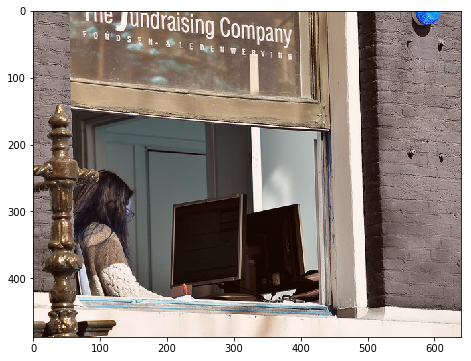

In [4]:
img = data_utils.get_example_from_path("../data/fcn_example.jpg", DataConfig.FCN32)

show_normalized(img)

### Step 4: Calculate Uncertainty
Create a device context in order to have calculations inside this context take place on a GPU.

Prediction:


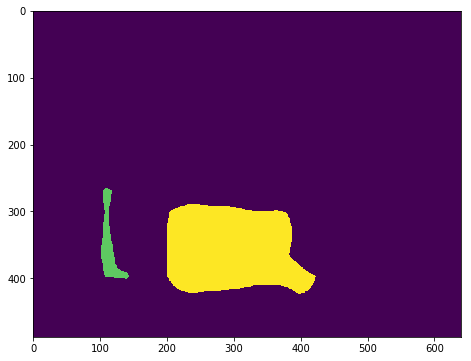

Predictive entropy (total uncertainty):


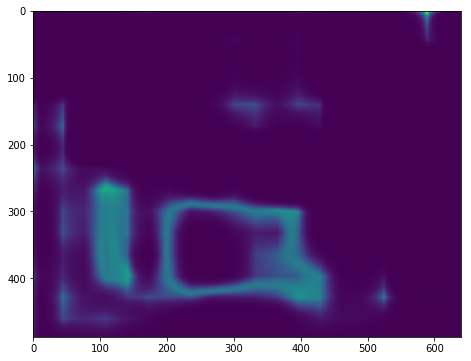

Mutual information (model uncertainty):


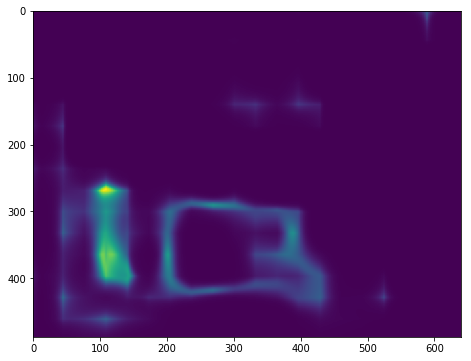

In [5]:
with vinsight.device("cpu"): # GPU device if available, e.g. "cuda:0"!
    pred, pred_entropy, mutual_info = ensemble(img)
    print("Prediction:")
    show(pred.argmax(dim=1))

    print("Predictive entropy (total uncertainty):")
    show(pred_entropy.sum(dim=1))

    print("Mutual information (model uncertainty):")
    show(mutual_info.sum(dim=1))

## Interpretation of results 
In contrast to the image classification example, we calculate predictions and uncertainties for each pixel of the image. 
Hence, we can visualize the pixel uncertainties as an image and add a color scheme to make interpretations easier (red = high uncertainty, blue = low uncertainty).

What can we see in these uncertainty images?

* **Total predictive entropy:** the total predictive uncertainty of each pixel, we can detect which pixels have high uncertainty and therefore, are predicted with low confidence.
* **Mutual Information:** the model uncertainty of each pixel, we can detect which pixels are predicted with low confidence due to the model.
* **Data Uncertainty:** we can detect which pixels are predicted with low confidence due to the quality of the data (image).